# Logistic Regression with PySpark

In [592]:
import findspark
findspark.init()

In [593]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler,StandardScaler
spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [594]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

## Read File

In [595]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("/Users/gulcanogundur/Downloads/diabetes.csv")
print("There are",df.count(),"rows",len(df.columns),"columns" ,"in the data.") 

There are 768 rows 9 columns in the data.


## Show Sample Data

In [596]:
df.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 4 rows



## Data Types of Columns

In [597]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



## Statistics

In [598]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


from pyspark.sql.functions import when
df=df.withColumn("Glucose",when(df.Glucose==0,np.nan).otherwise(df.Glucose))
df=df.withColumn("BloodPressure",when(df.BloodPressure==0,np.nan).otherwise(df.BloodPressure))
df=df.withColumn("SkinThickness",when(df.SkinThickness==0,np.nan).otherwise(df.SkinThickness))
df=df.withColumn("BMI",when(df.BMI==0,np.nan).otherwise(df.BMI))
df=df.withColumn("Insulin",when(df.Insulin==0,np.nan).otherwise(df.Insulin))

from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"],outputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"])
model=imputer.fit(df)
raw_data=model.transform(df)
raw_data.show(5)

## Target Variable Distribution

In [599]:
df.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



## Check For Null Values

In [600]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


## UDF 
### a ) Change Column Name and Data of Target Variable(OutCome)  

In [601]:
from pyspark.sql.functions import udf
y_udf = udf(lambda y: "No" if y==0 else "yes", StringType())

df=df.withColumn("HasDiabities", y_udf('OutCome')).drop("OutCome")

### b) Create a new column - Age Groups

In [602]:
def udf_multiple(age):
      if (age <= 25):
        return 'Under 25'
      elif (age >= 25 and age <= 35):
        return 'Between 25 and 35'
      elif (age > 35 and age < 50):
        return 'Between 36 and 49'
      elif (age >= 50):
        return 'Over 50'
      else: return 'N/A'

education_udf = udf(udf_multiple)
df=df.withColumn("Age_udf", education_udf('Age'))

#### Age Groups Distribution

In [603]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
tab = df.select(['Age_udf','Glucose']).\
   groupBy('Age_udf').\
       agg(F.count('Glucose').alias('UserCount'),
           F.mean('Glucose').alias('Glucose_AVG'),
           F.min('Glucose').alias('Glucose_MIN'),
           F.max('Glucose').alias('Glucose_MAX')).\
       withColumn('total',sum(col('UserCount')).over(window)).\
       withColumn('Percent',col('UserCount')*100/col('total')).\
       drop(col('total')).sort(desc("Percent"))

In [604]:
tab.show()

+-----------------+---------+------------------+-----------+-----------+------------------+
|          Age_udf|UserCount|       Glucose_AVG|Glucose_MIN|Glucose_MAX|           Percent|
+-----------------+---------+------------------+-----------+-----------+------------------+
|         Under 25|      267|110.71910112359551|          0|        199|         34.765625|
|Between 25 and 35|      231|121.67099567099567|         71|        198|         30.078125|
|Between 36 and 49|      181|125.74033149171271|          0|        197|23.567708333333332|
|          Over 50|       89| 139.5505617977528|         57|        197|11.588541666666666|
+-----------------+---------+------------------+-----------+-----------+------------------+



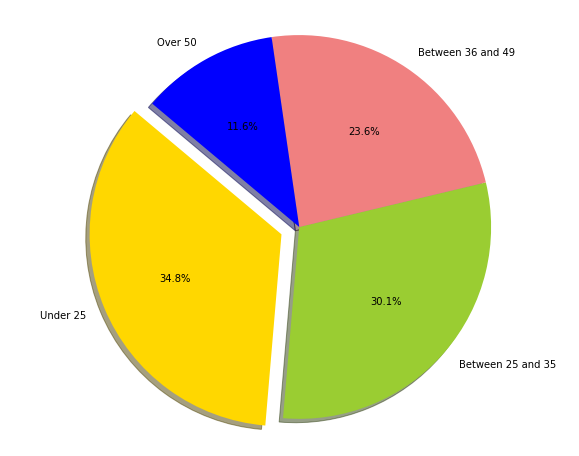

In [605]:
# Data to plot
labels = list(tab.select('Age_udf').distinct().toPandas()['Age_udf'])
sizes =  list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0.1, 0.0, 0 ,0.0 )  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Pearson Correlation

In [606]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df

DataFrame[Pregnancies: int, Glucose: int, BloodPressure: int, SkinThickness: int, Insulin: int, BMI: double, DiabetesPedigreeFunction: double, Age: int]

In [607]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


In [608]:
df=df.drop("Age")

In [609]:
df.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|HasDiabities|          Age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627|         yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351|          No|Between 25 and 35|
|          8|    183|           64|            0|      0|23.3|                   0.672|         yes|Between 25 and 35|
|          1|     89|           66|           23|     94|28.1|                   0.167|          No|         Under 25|
+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
only showing top 4 rows



# Preparing Data for Machine Learning

## First Method 

## StringIndexer

In [610]:
df2=df
df3=df
stringIndexer = StringIndexer()\
         .setInputCol ("Age_udf")\
         .setOutputCol ("Age_udfIndex")
Age_udfIndex_model=stringIndexer.fit(df2)
Age_udfIndex_df=Age_udfIndex_model.transform(df2)
Age_udfIndex_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0


## OneHotEncoderEstimator

In [611]:
encoder = OneHotEncoderEstimator()\
         .setInputCols (["Age_udfIndex"])\
         .setOutputCols (["Age_encoded"])
encoder_model=encoder.fit(Age_udfIndex_df)
encoder_df=encoder_model.transform(Age_udfIndex_df)
encoder_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)"
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)"
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"


## VectorAssembler

In [612]:
assembler = VectorAssembler()\
         .setInputCols (["Age_encoded","Pregnancies","Glucose","BloodPressure","SkinThickness",\
                         "Insulin","BMI","DiabetesPedigreeFunction"])\
         .setOutputCol ("vectorized_features")
assembler_df=assembler.transform(encoder_df)
assembler_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded,vectorized_features
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 3..."
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26..."
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23..."
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 2..."
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0,..."


## LabelIndexer

In [613]:
label_indexer = StringIndexer()\
         .setInputCol ("HasDiabities")\
         .setOutputCol ("label")
label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)
label_indexer_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded,vectorized_features,label
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 3...",1.0
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26...",0.0
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23...",1.0
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 2...",0.0
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0,...",1.0


# StandardScaler

In [614]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
scaler_df.toPandas().head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded,vectorized_features,label,features
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 3...",1.0,"[0.0, 0.0, 0.0, 1.78063837322, 4.62896091577, ..."


## Second Method 

## Pipeline

In [615]:
pipeline_stages=Pipeline()\
                .setStages([stringIndexer,encoder,assembler,label_indexer,scaler])
pipeline_model=pipeline_stages.fit(df3)
pipeline_df=pipeline_model.transform(df3)

In [616]:
pipeline_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded,vectorized_features,label,features
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 3...",1.0,"[0.0, 0.0, 0.0, 1.78063837322, 4.62896091577, ..."
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26...",0.0,"[0.0, 2.17914013334, 0.0, 0.296773062203, 2.65..."
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23...",1.0,"[0.0, 2.17914013334, 0.0, 2.37418449763, 5.723..."
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 2...",0.0,"[2.09847499384, 0.0, 0.0, 0.296773062203, 2.78..."
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0,...",1.0,"[0.0, 2.17914013334, 0.0, 0.0, 4.28491652338, ..."


## Third and Easiest Method

In [617]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler,StandardScaler
categoricalColumns = ['Age_udf']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'HasDiabities', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ["Pregnancies", 'Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

### Model Pipeline

In [618]:
cols = df.columns

In [619]:
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'HasDiabities',
 'Age_udf']

In [620]:
stages

[StringIndexer_3e4eb1acc351,
 OneHotEncoderEstimator_35a3711f9888,
 StringIndexer_f8f8a91e2c91,
 VectorAssembler_fcf91da4ad86,
 StandardScaler_bd88445efb8d]

In [621]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- HasDiabities: string (nullable = true)
 |-- Age_udf: string (nullable = true)



In [622]:
df.toPandas().head()

,label,features,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf
0,1.0,"[0.0, 0.0, 0.0, 1.78063837322, 4.62896091577, ...",6,148,72,35,0,33.6,0.627,yes,Over 50
1,0.0,"[0.0, 2.17914013334, 0.0, 0.296773062203, 2.65...",1,85,66,29,0,26.6,0.351,No,Between 25 and 35
2,1.0,"[0.0, 2.17914013334, 0.0, 2.37418449763, 5.723...",8,183,64,0,0,23.3,0.672,yes,Between 25 and 35
3,0.0,"[2.09847499384, 0.0, 0.0, 0.296773062203, 2.78...",1,89,66,23,94,28.1,0.167,No,Under 25
4,1.0,"[0.0, 2.17914013334, 0.0, 0.0, 4.28491652338, ...",0,137,40,35,168,43.1,2.288,yes,Between 25 and 35


# Train / Test Split

In [623]:
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 627
Test Dataset Count: 141


In [624]:
train.groupby("HasDiabities").count().show()

+------------+-----+
|HasDiabities|count|
+------------+-----+
|          No|  406|
|         yes|  221|
+------------+-----+



# Model Training

In [625]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)

In [626]:
predictions = lrModel.transform(test)
#predictions.select('Insulin', 'Glucose', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
predictions.toPandas().head(5)

,label,features,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,rawPrediction,probability,prediction
0,0.0,"(2.09847499384, 0.0, 0.0, 0.0, 3.90959536805, ...",0,125,96,0,0,22.5,0.262,No,Under 25,"[3.14296543686, -3.14296543686]","[0.95863064387, 0.0413693561304]",0.0
1,0.0,"(0.0, 2.17914013334, 0.0, 0.0, 2.84618542794, ...",0,91,80,0,0,32.4,0.601,No,Between 25 and 35,"[1.61743992866, -1.61743992866]","[0.834441762007, 0.165558237993]",0.0
2,0.0,"(0.0, 0.0, 2.35461525797, 0.593546124406, 4.03...",2,129,0,0,0,38.5,0.304,No,Between 36 and 49,"[-2.29278539875, 2.29278539875]","[0.0917222363601, 0.90827776364]",1.0
3,0.0,"(0.0, 0.0, 0.0, 1.48386531102, 3.56555097566, ...",5,114,74,0,0,24.9,0.744,No,Over 50,"[0.0965968442829, -0.0965968442829]","[0.524130450652, 0.475869549348]",0.0
4,0.0,"(0.0, 0.0, 0.0, 1.48386531102, 4.59768415282, ...",5,147,78,0,0,33.7,0.218,No,Over 50,"[-0.0860218829929, 0.0860218829929]","[0.478507780731, 0.521492219269]",1.0


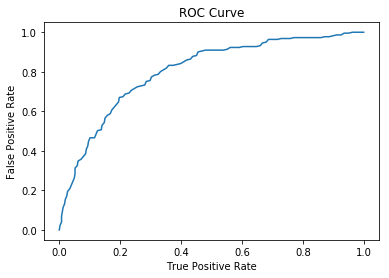

Training set areaUnderROC: 0.802236809843301


In [627]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

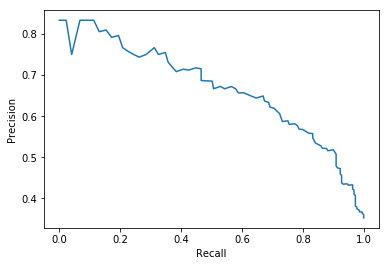

In [628]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Model Evaluation

In [629]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7704843820733362


In [630]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

In [631]:
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7770484382073334
